<a href="https://colab.research.google.com/github/ecordeiro/cefet/blob/main/busca_aleatoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import random
import altair as alt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
def plot_scatter_with_line_sea(populacao, x_title='X', y_title='Y', title='Scatter Plot with Connected Points'):
    # Extract points from population
    points = [(ind.fitness[0], ind.fitness[1]) for ind in populacao if ind.domination_count == 0]

    # Unzip points into separate lists for x and y
    x_values, y_values = zip(*points)

    # Create scatter plot
    sns.scatterplot(x=x_values, y=y_values, label='Scatter Plot')

    # Create line plot
    sns.lineplot(x=x_values, y=y_values, color='red', linewidth=2, label='Connected Line')

    # Add title and labels
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Display the plot
    plt.show()

# Example usage:
# plot_scatter_with_line_sea(populacao)


In [36]:
def plot_scatter_with_line(populacao, x_title='X', y_title='Y', title='Scatter Plot with Connected Points'):
    # Extract points from population
    points = [(ind.fitness[0], ind.fitness[1]) for ind in populacao if ind.domination_count == 0]

    # Create DataFrame from points
    source = pd.DataFrame({'x': [point[0] for point in points], 'y': [point[1] for point in points]})

    # Create scatter plot
    scatter = alt.Chart(source).mark_circle().encode(
        x=alt.X('x', axis=alt.Axis(title=x_title)),
        y=alt.Y('y', axis=alt.Axis(title=y_title)),
        tooltip=['x', 'y']
    ).interactive()

    # Create line plot
    line = alt.Chart(source).mark_line().encode(
        x='x',
        y='y'
    )

    # Combine scatter and line plots
    chart = scatter + line

    # Add title
    chart = chart.properties(title=title)

    # Display the plot
    chart.display()

# Example usage:
# plot_scatter_with_line(populacao)


In [37]:
class Individual:
    def __init__(self, chromosome_length, limites):
        # Inicializa um indivíduo com um cromossomo aleatório
        self.fitness = None
        self.dominated_solutions = []  # Soluções dominadas por este indivíduo
        self.domination_count = 0  # Contagem de quantos indivíduos dominam este indivíduo
        self.limite_inferior, self.limite_superior = limites
        self.chromosome = [np.random.uniform(self.limite_inferior,self.limite_superior) for _ in range(chromosome_length)]
        self.crowding_distance = 0

def f1(ind):
    n = len(ind.chromosome)
    valor = sum([(elemento**2 - 4) - 10 * np.cos(2 * np.pi * (elemento**2 - 4)) for elemento in ind.chromosome])
    return 10 * n + valor

def f2(ind):
    n = len(ind.chromosome)
    valor = sum([(elemento**2 - 10 * np.cos(2 * np.pi * elemento)) for elemento in ind.chromosome])
    return 10 * n + valor

def dominancia(fitness1, fitness2):
    # Verifica se fitness1 domina fitness2
    return all(fitness1[i] <= fitness2[i] for i in range(len(fitness1))) and any(fitness1[i] < fitness2[i] for i in range(len(fitness1)))

def calcula_domininancia_populacao(p):
    # Zera as listas de soluções dominadas e contagens de dominação
    for ind in p:
        ind.dominated_solutions = []

    # Calcula as soluções dominadas e atualiza a contagem de dominação para cada indivíduo
    for i in range(len(p)):
        for j in range(i + 1, len(p)):
            if dominancia(p[i].fitness, p[j].fitness):
                p[j].dominated_solutions.append(i)
                p[i].domination_count += 1
            elif dominancia(p[j].fitness, p[i].fitness):
                p[i].dominated_solutions.append(j)
                p[j].domination_count += 1
    return p

def calcula_crowding_distance(p):
    # Calcula a distância de multidão de cada indivíduo
    for ind in p:
        ind.crowding_distance = 0

    num_objectives = len(p[0].fitness)
    # Calcula a distância de multidão para cada objetivo
    for m in range(num_objectives):
        p.sort(key=lambda x: x.fitness[m])
        p[0].crowding_distance = float('inf')
        p[-1].crowding_distance = float('inf')
        for i in range(1, len(p) - 1):
            p[i].crowding_distance += (p[i + 1].fitness[m] - p[i - 1].fitness[m])
    return p

def gerar_populacao(population_size,chromosome_length,limites):
    # population_size = 50
    # chromosome_length = 2
    # limites = (-5.12, 5.12)
    populacao = [Individual(chromosome_length, limites) for _ in range(population_size)]

    for p in populacao:
        p.fitness = [f1(p),f2(p)]

    return populacao


Solução 0 para 55 gerações e n=2. Pontos não dominados: 7


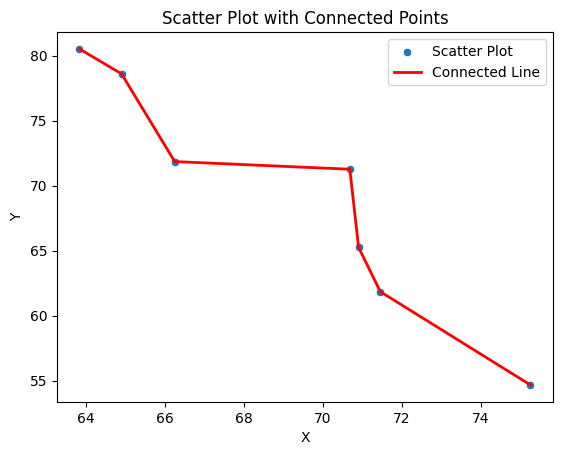

Solução 1 para 55 gerações e n=2. Pontos não dominados: 8


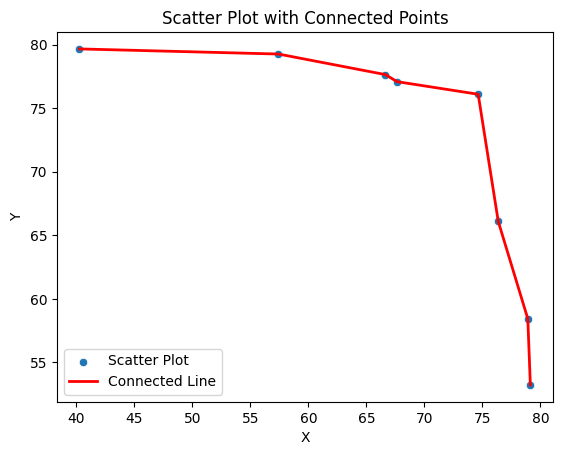

Solução 2 para 55 gerações e n=2. Pontos não dominados: 5


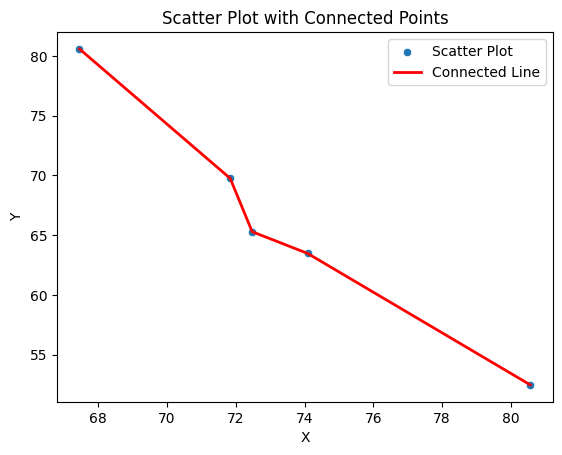

Solução 3 para 55 gerações e n=2. Pontos não dominados: 9


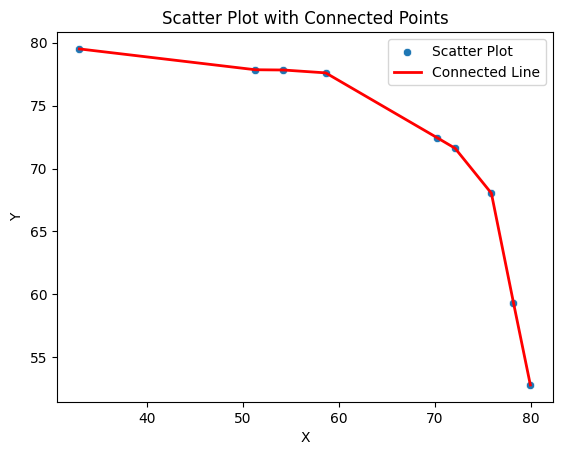

Solução 4 para 55 gerações e n=2. Pontos não dominados: 5


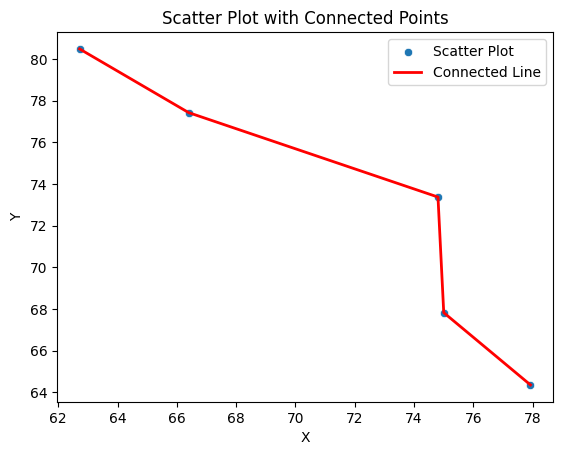

Solução 5 para 55 gerações e n=2. Pontos não dominados: 9


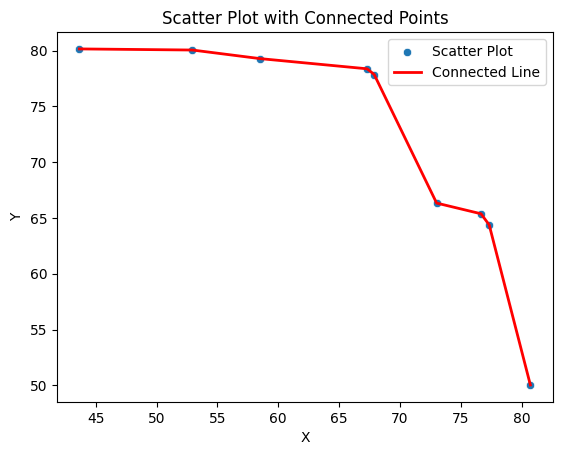

Solução 6 para 55 gerações e n=2. Pontos não dominados: 8


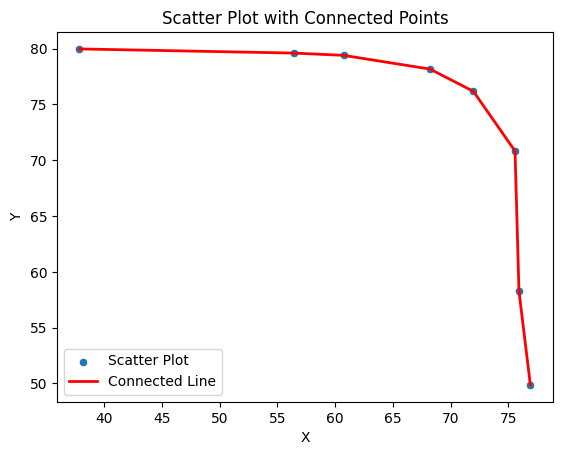

Solução 7 para 55 gerações e n=2. Pontos não dominados: 6


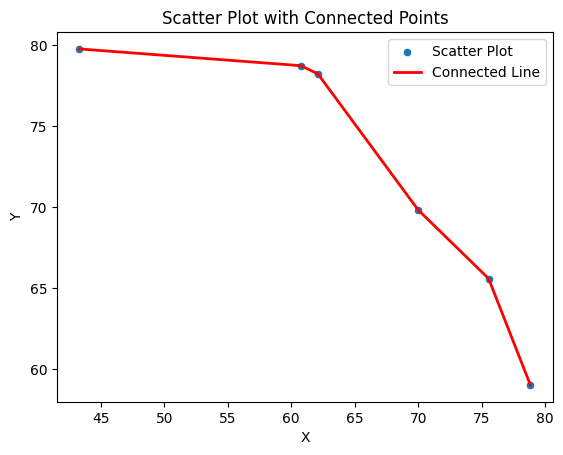

Solução 8 para 55 gerações e n=2. Pontos não dominados: 7


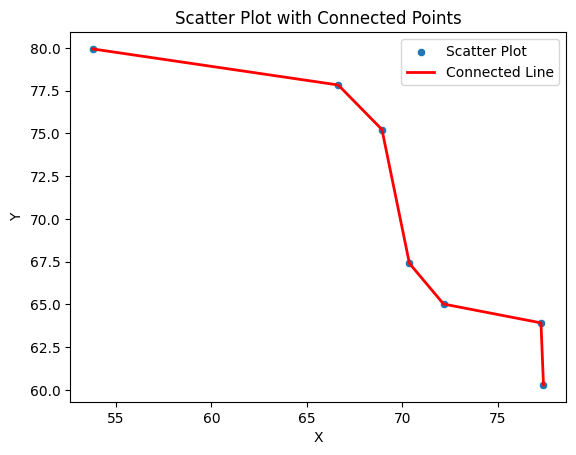

Solução 9 para 55 gerações e n=2. Pontos não dominados: 5


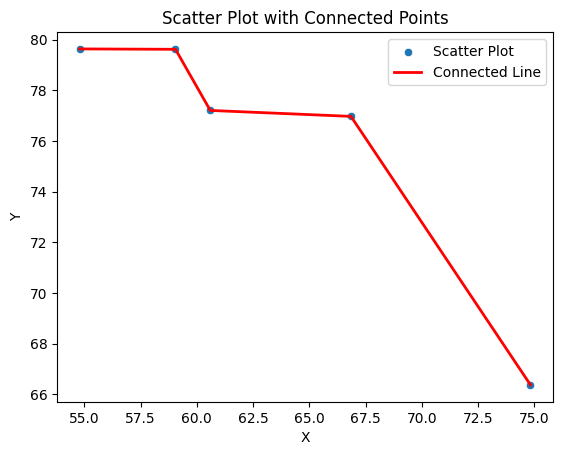

In [40]:
tamanho_cromossomos = 2

for i in range(0, 10):

    qtd_individuos = 200
    limites = (-5.12, 5.12)

    populacao = gerar_populacao(qtd_individuos,tamanho_cromossomos,limites)

    num_geracoes = 55
    qtd_individuos = 50
    limites = (-5.12, 5.12)

    for _ in range(num_geracoes):
        #Cria nova população
        nova_geracao = gerar_populacao(qtd_individuos,tamanho_cromossomos,limites)
        pop_total = populacao + nova_geracao
        populacao_total = calcula_domininancia_populacao(pop_total)
        populacao_total = calcula_crowding_distance(pop_total)
        populacao_total.sort(key=lambda x: (x.domination_count, -x.crowding_distance))
        populacao = populacao_total[:len(populacao)]  # Seleciona os melhores indivíduos

    non_dominated_solutions = [ind for ind in populacao if ind.domination_count == 0]

    print(f"Solução {i} para {num_geracoes} gerações e n={tamanho_cromossomos}.", f"Pontos não dominados: {len(non_dominated_solutions)}")

    #plot_scatter_with_line(populacao)
    plot_scatter_with_line_sea(populacao)
